# Multi-track hit classification with CNNs

Let's see how well the conv net model(s) can disambiguate hits into multiple track assignments.

As with the LSTM_Toy_MultiTrack fomulation, the data structure is basically an image with channels for each track plus a channel for the raw event data.

In [15]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers
from matplotlib import pyplot as plt

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_input_and_pred, draw_2d_event

%matplotlib notebook

In [42]:
def draw_train_history(history, figsize=(9,4)):
    train_accs = [np.array(history.history[k]) for k in history.history.keys()
                  if not k.startswith('val') and '_acc' in k]
    val_accs = [np.array(history.history[k]) for k in history.history.keys()
                if k.startswith('val') and '_acc' in k]
    avg_train_acc = sum(train_accs) / len(train_accs)
    avg_val_acc = sum(val_accs) / len(val_accs)
    # Plot the loss
    fig = plt.figure(figsize=figsize)
    plt.subplot(121)
    epochs = history.epoch
    plt.plot(epochs, history.history['loss'], label='Training set')
    plt.plot(epochs, history.history['val_loss'], label='Validation set')
    plt.title('Loss')
    plt.legend(loc=0)
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    # Plot the accuracy
    plt.subplot(122)
    plt.plot(epochs, avg_train_acc, label='Training set average')
    plt.plot(epochs, avg_val_acc, label='Validation set average')
    plt.ylim((0,1))
    plt.title('Accuracy')
    plt.xlabel('Training epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.tight_layout()
    return fig

def draw_outputs(event, preds, figsize=(11,4), nrows=1, ncols=3):
    fig = plt.figure(figsize=figsize)
    # Draw the input
    plt.subplot(nrows, ncols, 1)
    draw_2d_event(event, title='Model input')
    # Draw each of the outputs
    for itrk in range(len(preds)):
        plt.subplot(nrows, ncols, itrk+2)
        draw_2d_event(preds[itrk], title='Model prediction %i' % itrk)
    return fig

def history_report(history):
    """Report on the final loss and accuracies"""
    keys = sorted(history.history.keys())
    print('Final losses')
    print('  train: %g' % history.history['loss'][-1])
    print('  valid: %g' % history.history['val_loss'][-1])
    print('Final accuracies')
    for key in keys:
        if '_acc' in key:
            print('  %s: %g' % (key, history.history[key][-1]))

In [34]:
def generate_data(num_event, det_shape, num_sig_tracks, seed_size, noise_prob):
    """Generate some data"""
    sig_tracks = [generate_straight_tracks(num_event, det_shape)
                  for _ in range(num_sig_tracks)]
    noise = generate_uniform_noise(num_event, det_shape, prob=noise_prob, 
                                   skip_layers=seed_size)
    return sig_tracks, noise

In [3]:
det_width = 48
det_depth = 48
det_shape = (det_depth, det_width)
seed_size = 6

In [4]:
num_event = 51200
num_tracks = 2
noise_prob = 0
sig_tracks, _ = generate_data(num_event, det_shape, num_tracks, 0, noise_prob)

In [5]:
events = sum(sig_tracks)
#events[events > 1] = 1

train_input = [t.copy() for t in sig_tracks] + [events]
for i in range(num_tracks):
    train_input[i][:,seed_size:,:] = 0
train_target = sig_tracks

In [54]:
def build_conv_model(det_shape, num_tracks):
    """A conv model which does per-channel softmax over pixels in a layer"""
    det_depth, det_width = det_shape
    # Separate input channels
    inputs = [layers.Input(shape=det_shape) for i in range(num_tracks+1)]
    # Add a channel dimension before merging
    reshape_layer = layers.Reshape((1,) + det_shape)
    shaped_inputs = [reshape_layer(i) for i in inputs]
    # Merge into one multi-channel image
    hidden = layers.merge(shaped_inputs, mode='concat', concat_axis=1)
    # Apply some convolutions
    for i in range(10):
        hidden = layers.Conv2D(32, 10, 10, border_mode='same', activation='relu')(hidden)
    # Final convolution without activation
    hidden = layers.Conv2D(num_tracks, 3, 3, border_mode='same')(hidden)
    # Split output channels
    split_outputs = [layers.Lambda(lambda x: x[:,i])(hidden) for i in range(num_tracks)]
    # Apply softmax to each layer
    softmax_layer = layers.TimeDistributed(layers.Activation('softmax'))
    outputs = [softmax_layer(o) for o in split_outputs]
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

def build_convae_model(det_shape, num_tracks=2):
    """A conv model which does per-channel softmax over pixels in a layer"""
    det_depth, det_width = det_shape
    # Separate input channels
    inputs = [layers.Input(shape=det_shape) for i in range(num_tracks+1)]
    # Add a channel dimension before merging
    reshape_layer = layers.Reshape((1,) + det_shape)
    shaped_inputs = [reshape_layer(i) for i in inputs]
    # Merge into one multi-channel image
    hidden = layers.merge(shaped_inputs, mode='concat', concat_axis=1)

    # Apply some convolutions
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)

    # Convolutions and up-sampling
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)

    # Final convolution without activation
    hidden = layers.Conv2D(num_tracks, 3, 3, border_mode='same')(hidden)

    # Split output channels
    split_outputs = [layers.Lambda(lambda x: x[:,i])(hidden) for i in range(num_tracks)]

    # Apply softmax to each layer
    softmax_layer = layers.TimeDistributed(layers.Activation('softmax'))
    outputs = [softmax_layer(o) for o in split_outputs]

    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

In [55]:
model0 = build_conv_model(det_shape, num_tracks=num_tracks)
model0.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 48, 48)        0                                            
____________________________________________________________________________________________________
input_14 (InputLayer)            (None, 48, 48)        0                                            
____________________________________________________________________________________________________
input_15 (InputLayer)            (None, 48, 48)        0                                            
____________________________________________________________________________________________________
reshape_5 (Reshape)              (None, 1, 48, 48)     0           input_13[0][0]                   
                                                                   input_14[0][0]          

In [56]:
batch_size = 128
num_epoch = 5
valid_frac = 0.2

In [57]:
# Fit the training data
history0 = model0.fit(train_input, train_target,
                      batch_size=batch_size, nb_epoch=num_epoch,
                      validation_split=valid_frac)

train0_pred = model0.predict(train_input)

Train on 40960 samples, validate on 10240 samples
Epoch 1/5
40960/40960 [==============================] - 139s - loss: 7.9745 - timedistributed_5_loss_1: 3.9928 - timedistributed_5_loss_2: 3.9817 - timedistributed_5_acc_1: 0.0140 - timedistributed_5_acc_2: 0.0139 - val_loss: 7.5784 - val_timedistributed_5_loss_1: 3.7812 - val_timedistributed_5_loss_2: 3.7971 - val_timedistributed_5_acc_1: 0.0230 - val_timedistributed_5_acc_2: 0.0232
Epoch 2/5
40960/40960 [==============================] - 139s - loss: 7.5366 - timedistributed_5_loss_1: 3.7670 - timedistributed_5_loss_2: 3.7696 - timedistributed_5_acc_1: 0.0249 - timedistributed_5_acc_2: 0.0247 - val_loss: 7.5350 - val_timedistributed_5_loss_1: 3.7678 - val_timedistributed_5_loss_2: 3.7672 - val_timedistributed_5_acc_1: 0.0258 - val_timedistributed_5_acc_2: 0.0273
Epoch 3/5
40960/40960 [==============================] - 139s - loss: 7.5244 - timedistributed_5_loss_1: 3.7610 - timedistributed_5_loss_2: 3.7634 - timedistributed_5_acc_1: 

Final losses
  train: 27.0523
  valid: 32.1698
Final accuracies
  timedistributed_5_acc_1: 0.00781403
  timedistributed_5_acc_2: 0.00736949
  val_timedistributed_5_acc_1: 0.00255127
  val_timedistributed_5_acc_2: 0.00156453


<IPython.core.display.Javascript object>


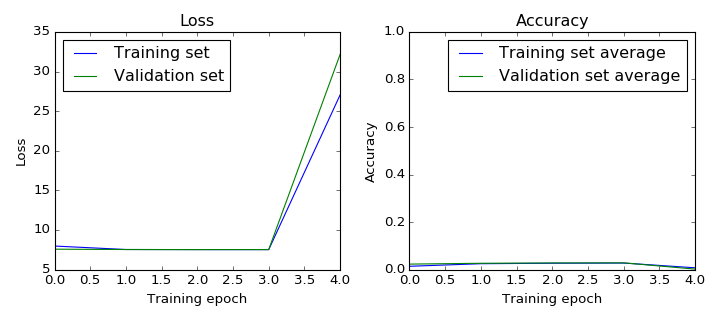

<IPython.core.display.Javascript object>


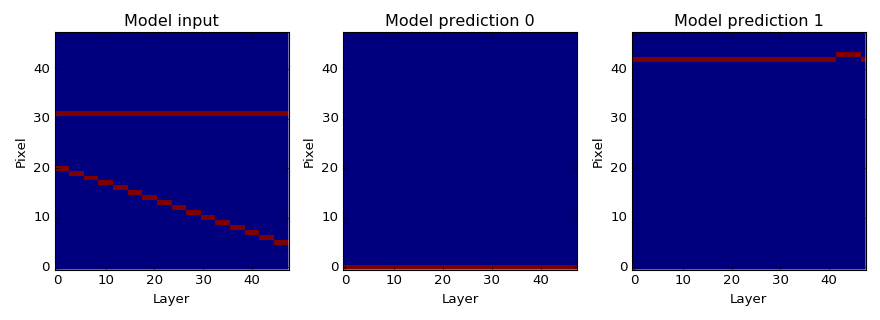

In [58]:
ievt = 1
history_report(history0)
fig0 = draw_train_history(history0)
fig1 = draw_outputs(events[ievt], [p[ievt] for p in train0_pred])